# Factor analysis on chemical abundances spaces

Authors: Yangda Bei, Yuan-Sen Ting

The following notebook acts as an interactive companion to research project (ASC) completed during the Summer session 2022 and contains the code for the latent factor model created for the ASC. Although such a model exists within the ``FactorAnalyzer`` package created by ``scikit-learn``, a factor model was created from scratch following ``Algorithm 21.1`` from Barber's *Bayesian Reasoning and Machine Learning* as an exercise in data analysis using Python and introduction to machine learning models. The notebook provides better readability of the individual steps performed using the algorithm.

Before we begin, let's import all the necessary packages.

In [2]:
%matplotlib inline

# import packages
import numpy as np
import pandas as pd
import seaborn as sns
import csv

from sklearn.decomposition import FactorAnalysis

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from cycler import cycler

#------------------------------------------------------------------------------------------------------------
# define plot properties

from matplotlib import rcParams
from matplotlib import rc
from matplotlib.colors import hsv_to_rgb
from mpl_toolkits.axes_grid1 import make_axes_locatable

def rgb(r,g,b):
    return (float(r)/256.,float(g)/256.,float(b)/256.)

cb2 = [rgb(0,0,0), rgb(255,127,0), rgb(31,120,180), rgb(51,160,44), rgb(227,26,28), \
       rgb(166,206,227), rgb(253,191,111), rgb(178,223,138), rgb(251,154,153)]

rcParams['figure.figsize'] = (9,8)
rcParams['figure.dpi'] = 300

rcParams['lines.linewidth'] = 1

rcParams['axes.prop_cycle'] = cycler('color', cb2)
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid'] = False

rcParams['patch.facecolor'] = cb2[0]
rcParams['patch.edgecolor'] = 'white'

rcParams['font.size'] = 10
rcParams['font.weight'] = 300

***

## 1. Creating mock factors and dataset

First, we set our latent factor vectors, $\mathbf{v}\in\mathbb{R}^{H\times D}$. We wish to compare how well these latent factors can be recovered by using the ``FactorAnalyzer`` package and by using our own factor model. The data used will be drawn from ``latentfactors.csv``. It consists of $H=5$ latent factors with $D=25$ dimensions drawn from random for the sake of consistency however there is the option to generate random factors with different values for ``num_latent`` and ``num_dimension``.

Run the first code block for randomly generated latent factors.

Run the second code block to get latent factors from ``latentfactors.csv``.

In [6]:
#----------------------------------------------------
# run for randomly generated latent factors
#----------------------------------------------------

# number of latent factors
num_latent = 5

# number of observed dimensions
num_dimension = 25

# make latent vectors
v = np.random.normal(size=(num_latent, num_dimension))
print(v)
print(v.shape)

[[ 1.02399812e+00 -5.20909957e-01 -1.41252254e+00 -2.73529287e-01
  -5.11697690e-02 -8.84045482e-01  1.15015533e+00 -1.59049418e+00
   6.46404426e-01  2.66889319e+00 -1.46532453e+00 -1.47029178e+00
  -6.59562659e-01  9.86501167e-01  5.35214336e-01 -1.80049795e+00
  -1.83733012e+00 -1.20102134e+00 -1.32553431e-01 -5.93265251e-01
   1.15809546e+00 -1.22612995e-03  7.38153272e-01  3.64144291e-02
   6.18754331e-01]
 [-7.34183845e-01 -9.48088622e-03 -1.51652226e+00  5.08195866e-01
  -1.30788856e+00  7.82883021e-01  5.66316478e-01 -1.86213626e+00
   2.01510550e+00 -4.69147606e-01  6.01563954e-02  1.50145650e-01
  -5.71967712e-01  6.61560902e-01  4.87897103e-01  4.94945743e-01
  -1.45643483e+00 -1.56469607e-02  2.45938232e-02 -3.58030019e-01
   5.93396451e-01  7.21986452e-01  1.00224762e+00 -6.91846208e-01
   1.35936801e+00]
 [-2.93165704e-02 -7.03058663e-01 -5.24122974e-01  1.60977190e-01
  -1.86175746e-01 -7.64142308e-01  2.91806585e-01  1.65865139e+00
  -2.77982572e-01  6.68556415e-02 -8.5

In [7]:
#-------------------------------------------------------
# run for latent factors used in report
#-------------------------------------------------------

num_latent = 5

num_dimension = 25

with open("latentfactors.csv") as latent_factors:
    v = np.loadtxt("latentfactors.csv", delimiter = ",")
print(v)
print(v.shape)

[[ 0.18144492  0.05323894  0.34088565 -0.36324156  0.08225544 -0.1623482
   0.1973469  -0.15116405 -0.16927311 -0.2293212   0.19331962 -0.19816031
   0.11358129 -0.28013076 -0.07936869  0.05707328 -0.16864602  0.03421699
   0.10817121  0.0891394  -0.0477453  -0.32008367 -0.37347567 -0.25003293
   0.07982172]
 [-0.09641812 -0.30614026 -0.04553841 -0.02153698  0.11671276 -0.27778468
  -0.2844911  -0.16038423 -0.25492295  0.08910172  0.32999751  0.17901025
   0.31988332 -0.09962169 -0.25535439 -0.28470375  0.013457   -0.29531394
  -0.13637721 -0.15072999  0.07810613  0.01908932 -0.20798678  0.08362075
   0.19797542]
 [-0.1719361  -0.03376968  0.0170414  -0.05939308  0.08743548 -0.12904541
  -0.3228088   0.05734221  0.07153515  0.04004422 -0.01872197  0.0028193
  -0.4266414  -0.11524609  0.40492273 -0.34630958 -0.08891662  0.03492344
   0.24299487  0.17455663 -0.11376375  0.07156838 -0.15759426 -0.131246
   0.43433134]
 [ 0.12413872  0.18537115  0.2127099   0.07528541  0.09231999 -0.337118

Next, we create a mock dataset with $D$ dimensions (features) and $N$ samples of random values drawn from a Gaussian. To do so, we first create our coefficients for our factor loading matrix $\mathbf{\alpha}\in\mathbb{R}^{N\times H}$, then multiply with the $\mathbf{v}$ factors. 

The mock dataset used will be drawn from ``mockdata.csv`` with $D=25$ and $N=10\,000$. Note that for samples of order >$10^4$, memory allocation will become an issue. Future improvements include improving scalability of SVD algorithm (``dask.array.linalg.svd`` is a promising solution).

Run the first code block for randomly generated samples.

Run the second code block to get dataset from ``mockdata.csv``.

In [84]:
#-------------------------------------------------------
# run for randomly generated samples
#-------------------------------------------------------

# number of mock samples
num_sample = 10**4

# make the factor loading matrix (N x H)
alpha = np.random.normal(size=(num_sample, num_latent))

# make mock samples (N x D)
V = np.dot(alpha,v)
print(V.shape)

(10000, 25)


In [8]:
#-------------------------------------------------------
# run for dataset used in analysis in report
#-------------------------------------------------------

num_sample = 10**4

with open("mockdata.csv") as mock_data:
    V = np.loadtxt("mockdata.csv", delimiter = ",")
print(V.shape)

(10000, 25)


Now that we have made our dataset with underlying factors, we can visualise the correlation between the $D$ features. 

In [9]:
# reads the dataset into a Pandas dataframe for convenience in
# creating heatmap
data = pd.DataFrame(V)
data.rename(columns={i:i+1 for i in range(num_dimension)}, inplace=True)

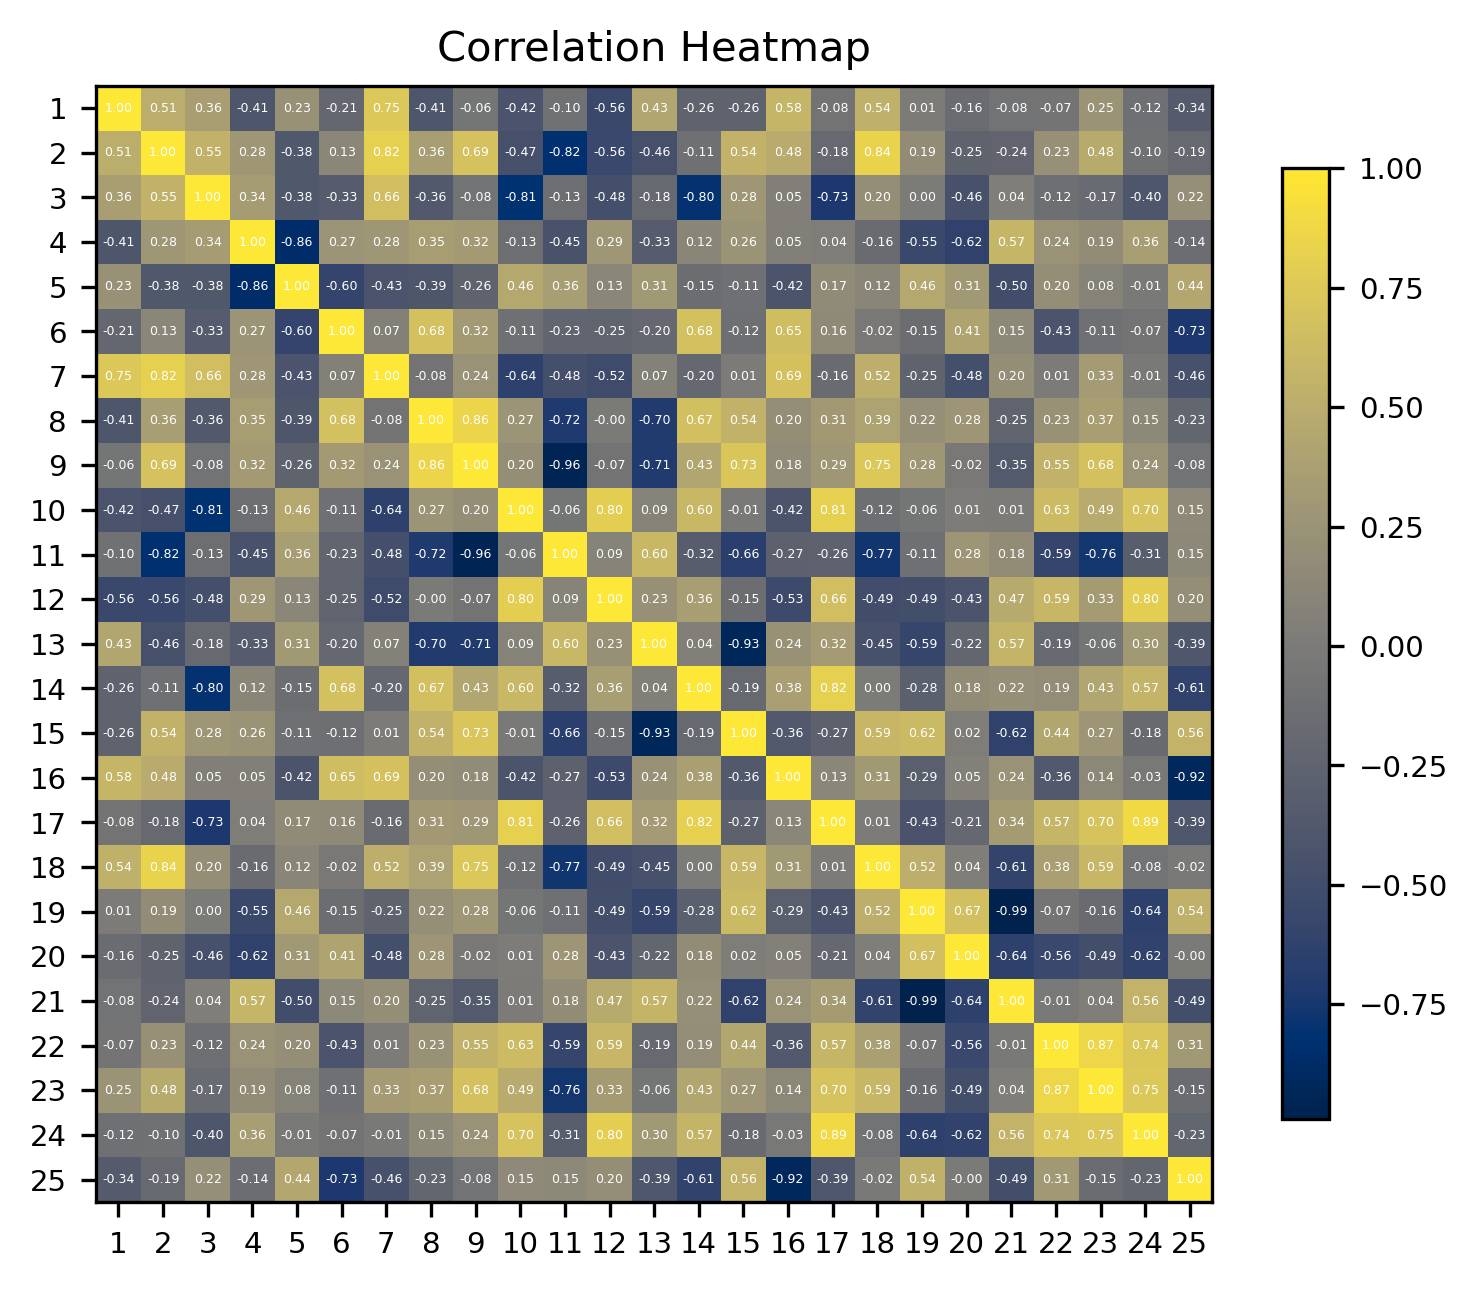

In [10]:
# creates correlation heatmap
plt.title("Correlation Heatmap", fontsize = 10)

plt.imshow(data.corr(), cmap = "cividis", interpolation = "none")
plt.xticks(range(len(data.columns)), data.columns)
plt.yticks(range(len(data.columns)), data.columns)

plt.gcf().set_size_inches(6,6)
plt.tick_params(labelsize=7)
cbar = plt.colorbar(shrink = 0.7)
cbar.ax.tick_params(labelsize=7)

# show correlation value of each square
labels = data.corr().values
for y in range(labels.shape[0]):
    for x in range(labels.shape[1]):
        plt.text(x,y, "{:.2f}".format(labels[y,x]), ha = "center", 
                 va="center", color = "white", fontsize = 3)

***

## 2. Factor analysis using ``FactorAnalyzer`` by ``scikit-learn``

The following code blocks generate an exploratory factor observation of the underlying latent factors of $\mathbf{V}$ using the ``FactorAnalyzer`` package after specifying the number of components wished to be extracted. 

First, we must add some noise in order to properly define the likelihood of our data. We map two dimensions of the mockdata after noise has been added.

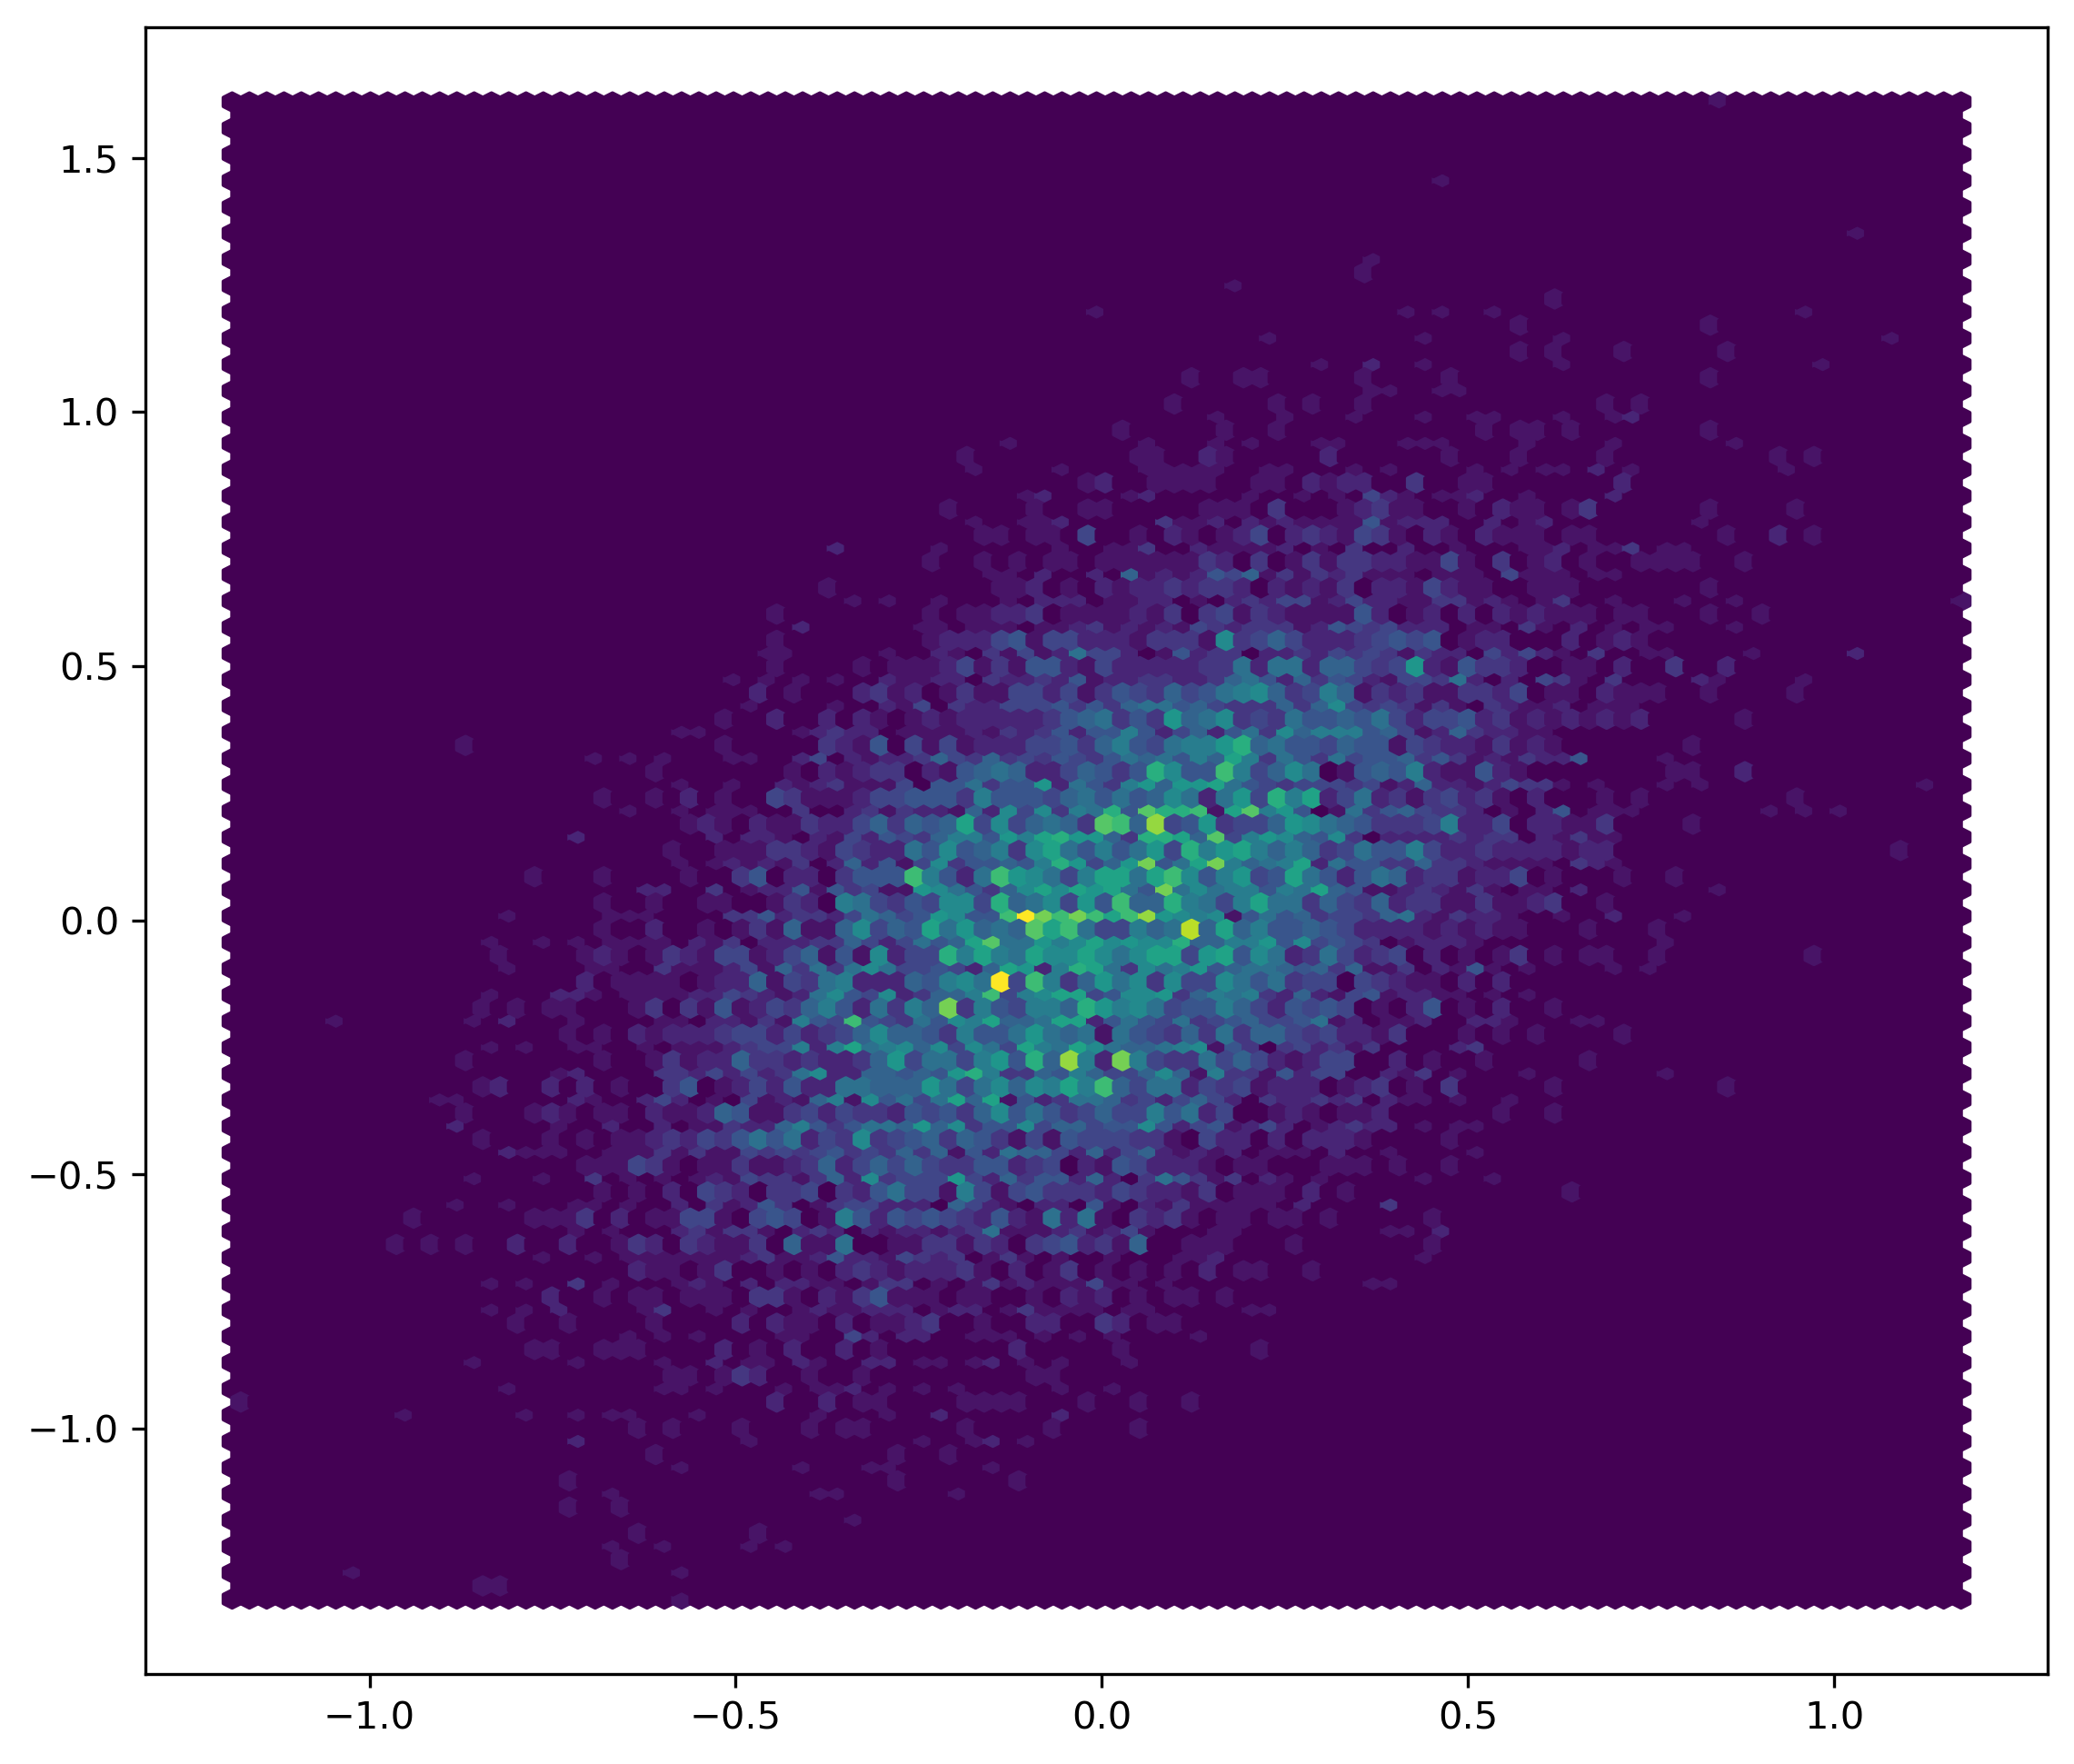

In [11]:
# add noise 
V_noise = V+0.01*np.random.normal(size=V.shape)

# show two of the dimensions
plt.hexbin(V_noise[:,0], V_noise[:,1])

For *confirmatory* factor analysis, we already know the number of latent factors and are just *confirming* that they are there in the dataset. For *exploratory* factor analysis on the other hand, we need to determine the number of compenents that are hidden before we can call ``.fit_transform()``. Since we made up the number of latent factors, we will just determine the number of factors as a check.

To find out how many factors we can extract, we look to the eigenvalues of the correlation matrix. These eigenvalues tell us how much variance of the variables a factor explains. Therefore, an eigenvalue that is $>1$ means the factor that corresponds to it explains the variance of more than one variable.

/Users/yangd/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


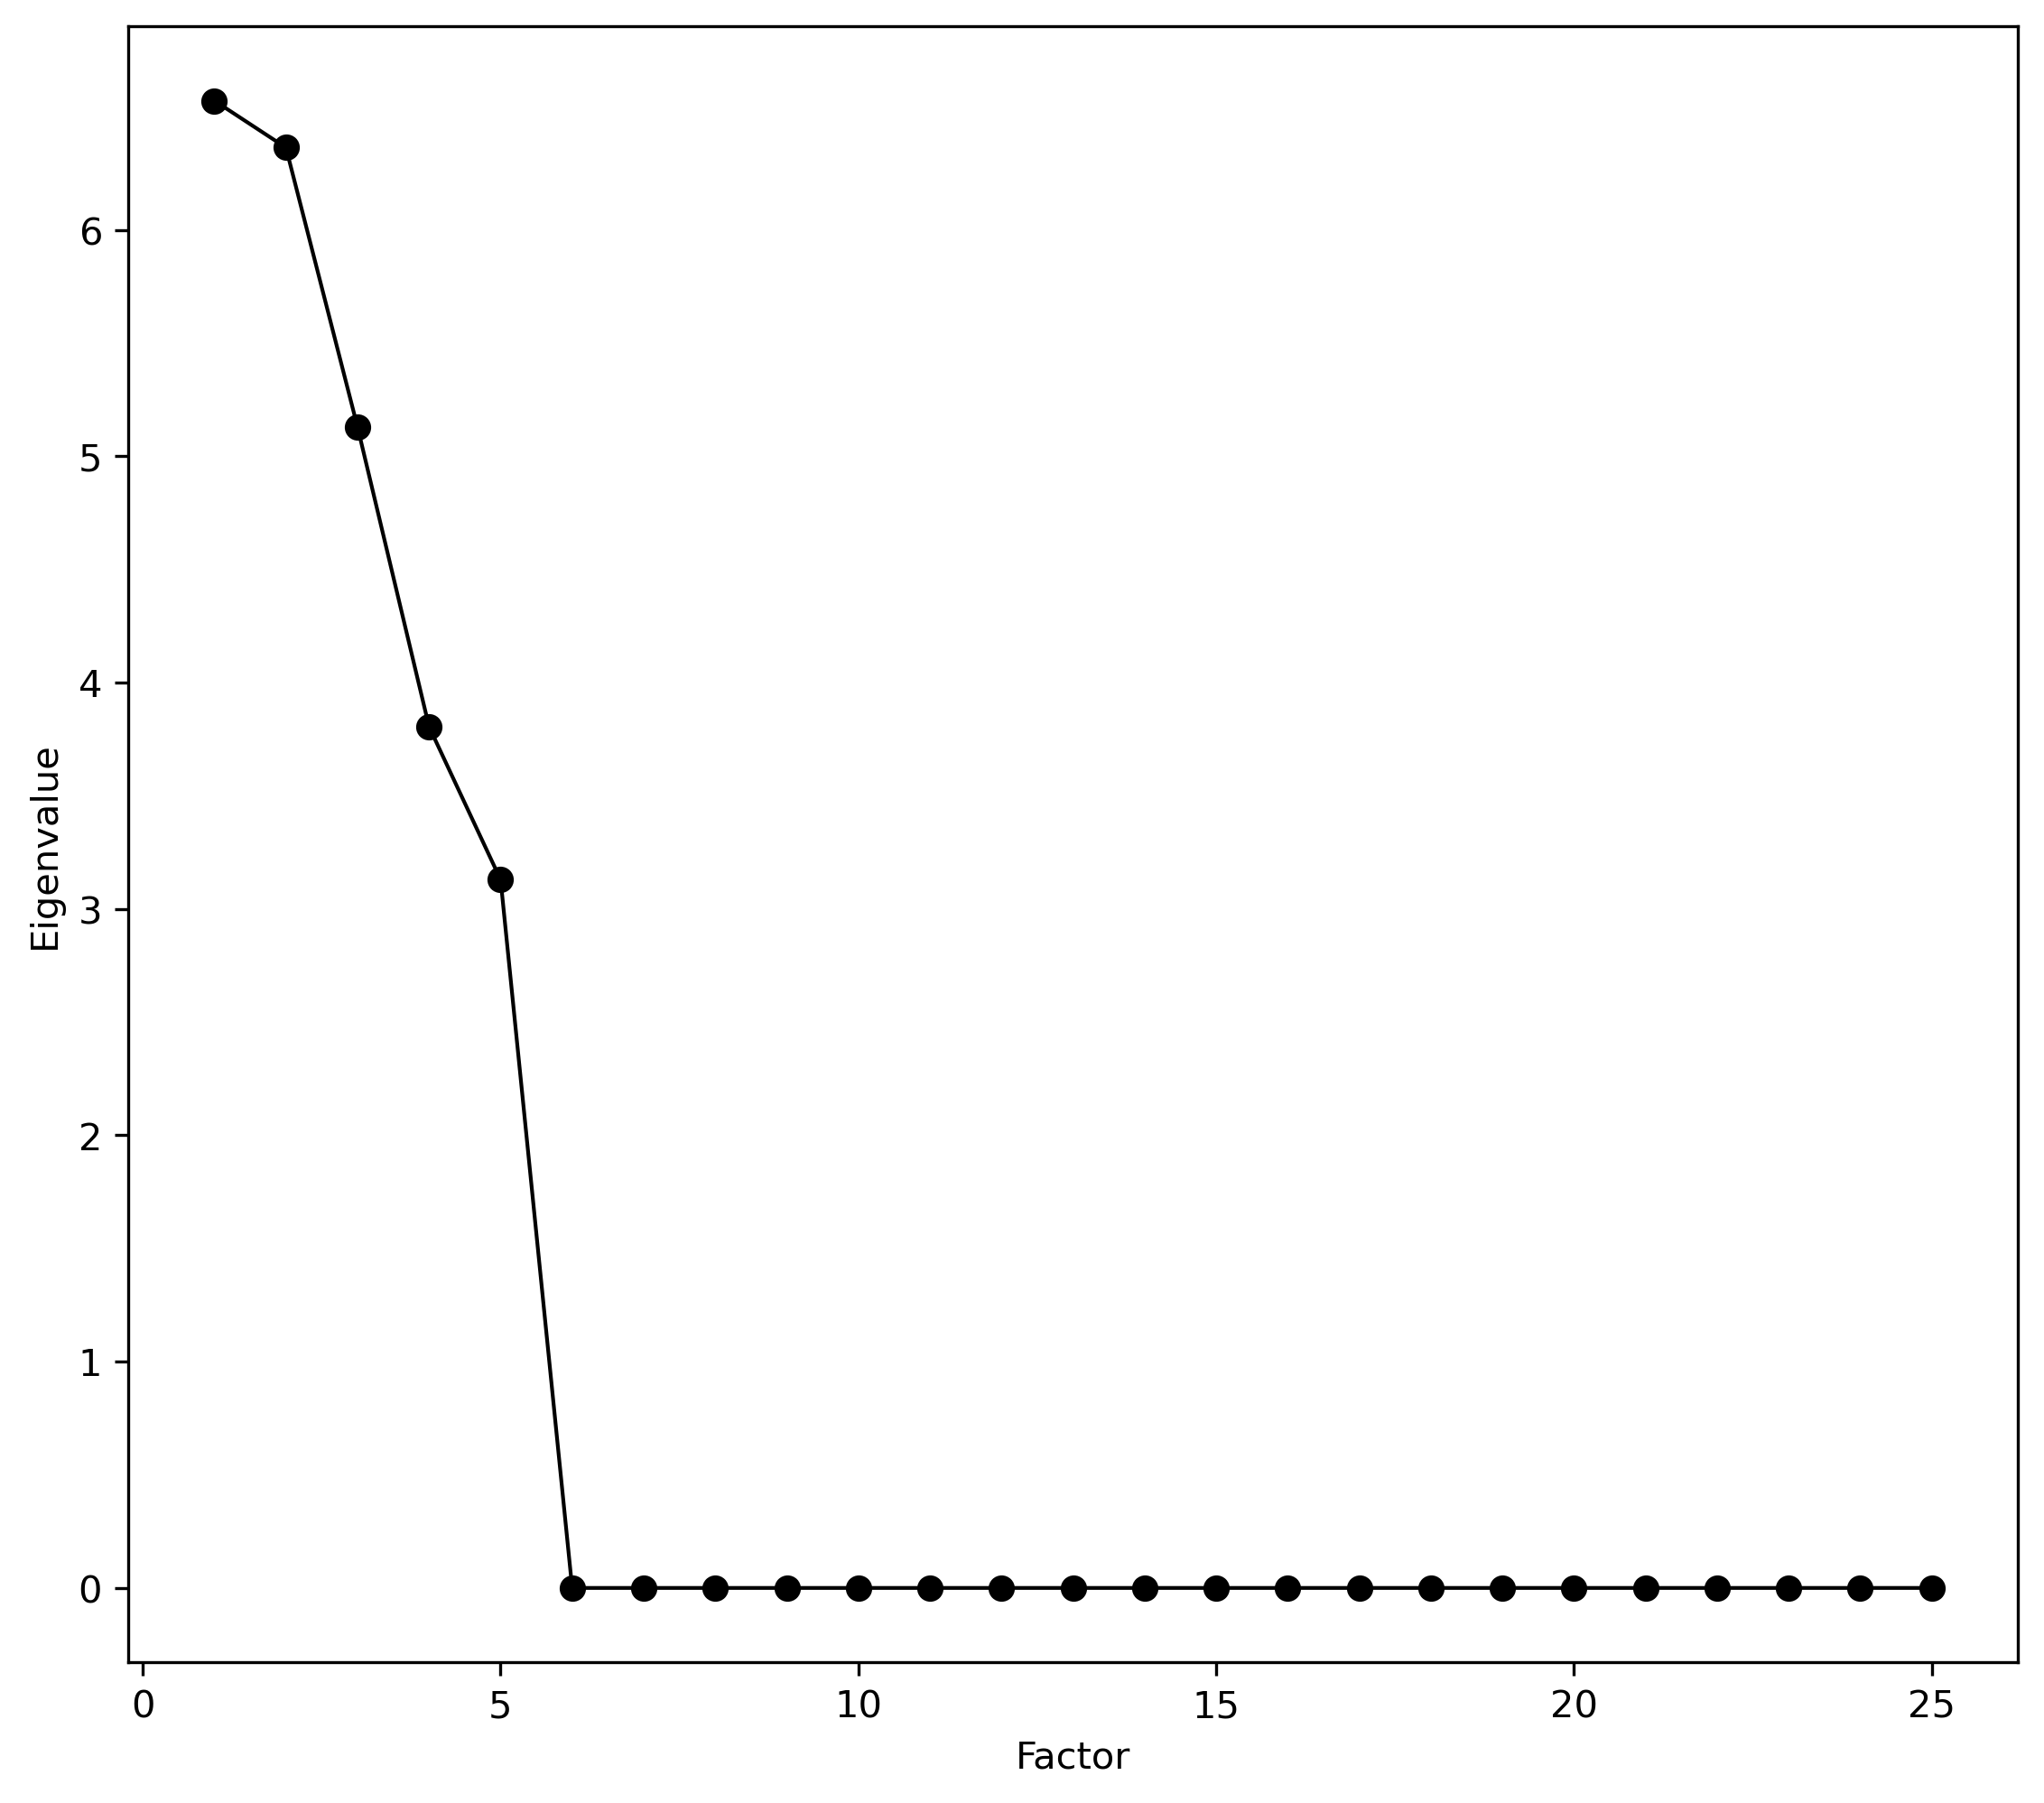

In [12]:
# convert correlation DataFrame made in section 1 to an
# ndarray
correlation = data.corr()
correlation.to_numpy

# extract eigenvalues and sort them in descending order
evalues,_ = np.linalg.eig(correlation)
evalues[::-1].sort()

#----------------------------------------------------------

# scree plot
plt.plot(range(1, correlation.shape[1] + 1),evalues, 'o-')

plt.ylabel("Eigenvalue")
plt.xlabel("Factor")

plt.show()

We can see that the number of factors matches the value of ``num_latent``! Now, we can call ``.fit_transform()`` on the dataset to transform all the features using its mean and variance.

In [13]:
# perform latent decomposition using sklearn package
fa = FactorAnalysis(n_components=num_latent, noise_variance_init=0.01*np.ones(num_dimension))
v_transformed = fa.fit_transform(V_noise)

print(v_transformed)

[[-3.23178271  1.21488334 -0.97801137  0.36050949 -0.09293231]
 [ 0.22314407  0.84158427 -0.58851371 -0.75278866  0.43745024]
 [ 0.44813322 -0.47673864  0.50266882 -0.01033397  1.23017697]
 ...
 [ 0.59722122 -0.77967568  0.18277034 -0.190905    0.05523143]
 [ 1.52966645  0.80645362  2.11208611  0.74928167 -0.21306815]
 [ 0.64746442 -0.26492377 -1.07476538 -0.93476528  0.73915553]]


The factors are then extracted using ``.components`` and reordered by how close they are to the true latent factors. The components are then compared to the true latent factors.

In [14]:
# extracts components
fa_components = fa.components_
print(fa_components)

[[ 0.02057389  0.2979521   0.17313483  0.52975695 -0.20591946  0.06102188
   0.32882526  0.12643116  0.26730483 -0.00565693 -0.41871948  0.01232611
  -0.28033122  0.06814356  0.31017288  0.10193605  0.04818377  0.21148459
  -0.05279363 -0.26982812  0.01655479  0.34015429  0.49414553  0.13835402
  -0.07005369]
 [-0.12347881 -0.06192389 -0.12292617 -0.1893277   0.22664715 -0.26224464
  -0.34435354  0.03545349  0.08868662  0.16661833 -0.05185723  0.09319867
  -0.27327438 -0.05221196  0.34272228 -0.38412804  0.00887115  0.07314912
   0.20376186  0.07502859 -0.10370009  0.30153505  0.13204884  0.01252424
   0.43962684]
 [ 0.01754804  0.14843084  0.41416905  0.05852125 -0.11084185 -0.02395696
   0.14568897 -0.01720135 -0.0078561  -0.24382032  0.00129197 -0.19419914
  -0.30610788 -0.25649199  0.25512877 -0.02660522 -0.20763735  0.06968259
   0.16508983  0.09691007 -0.07058248 -0.25210835 -0.37103635 -0.27818576
   0.18378627]
 [ 0.03720801  0.10262364 -0.25601119 -0.31353823  0.03811804  0.31

In [15]:
# reorders the latent vectors
ind_best = np.zeros(num_latent)

for i in range(num_latent):
    ind_temp = -999
    diff_temp = np.inf
    
    for j in range(num_latent):
        diff = np.sum((v[i,:] - fa_components[j,:])**2)
        if diff < diff_temp:
            diff_temp = diff
            ind_temp = j
            
    ind_best[i] = ind_temp

print(ind_best)

[2. 4. 1. 0. 3.]


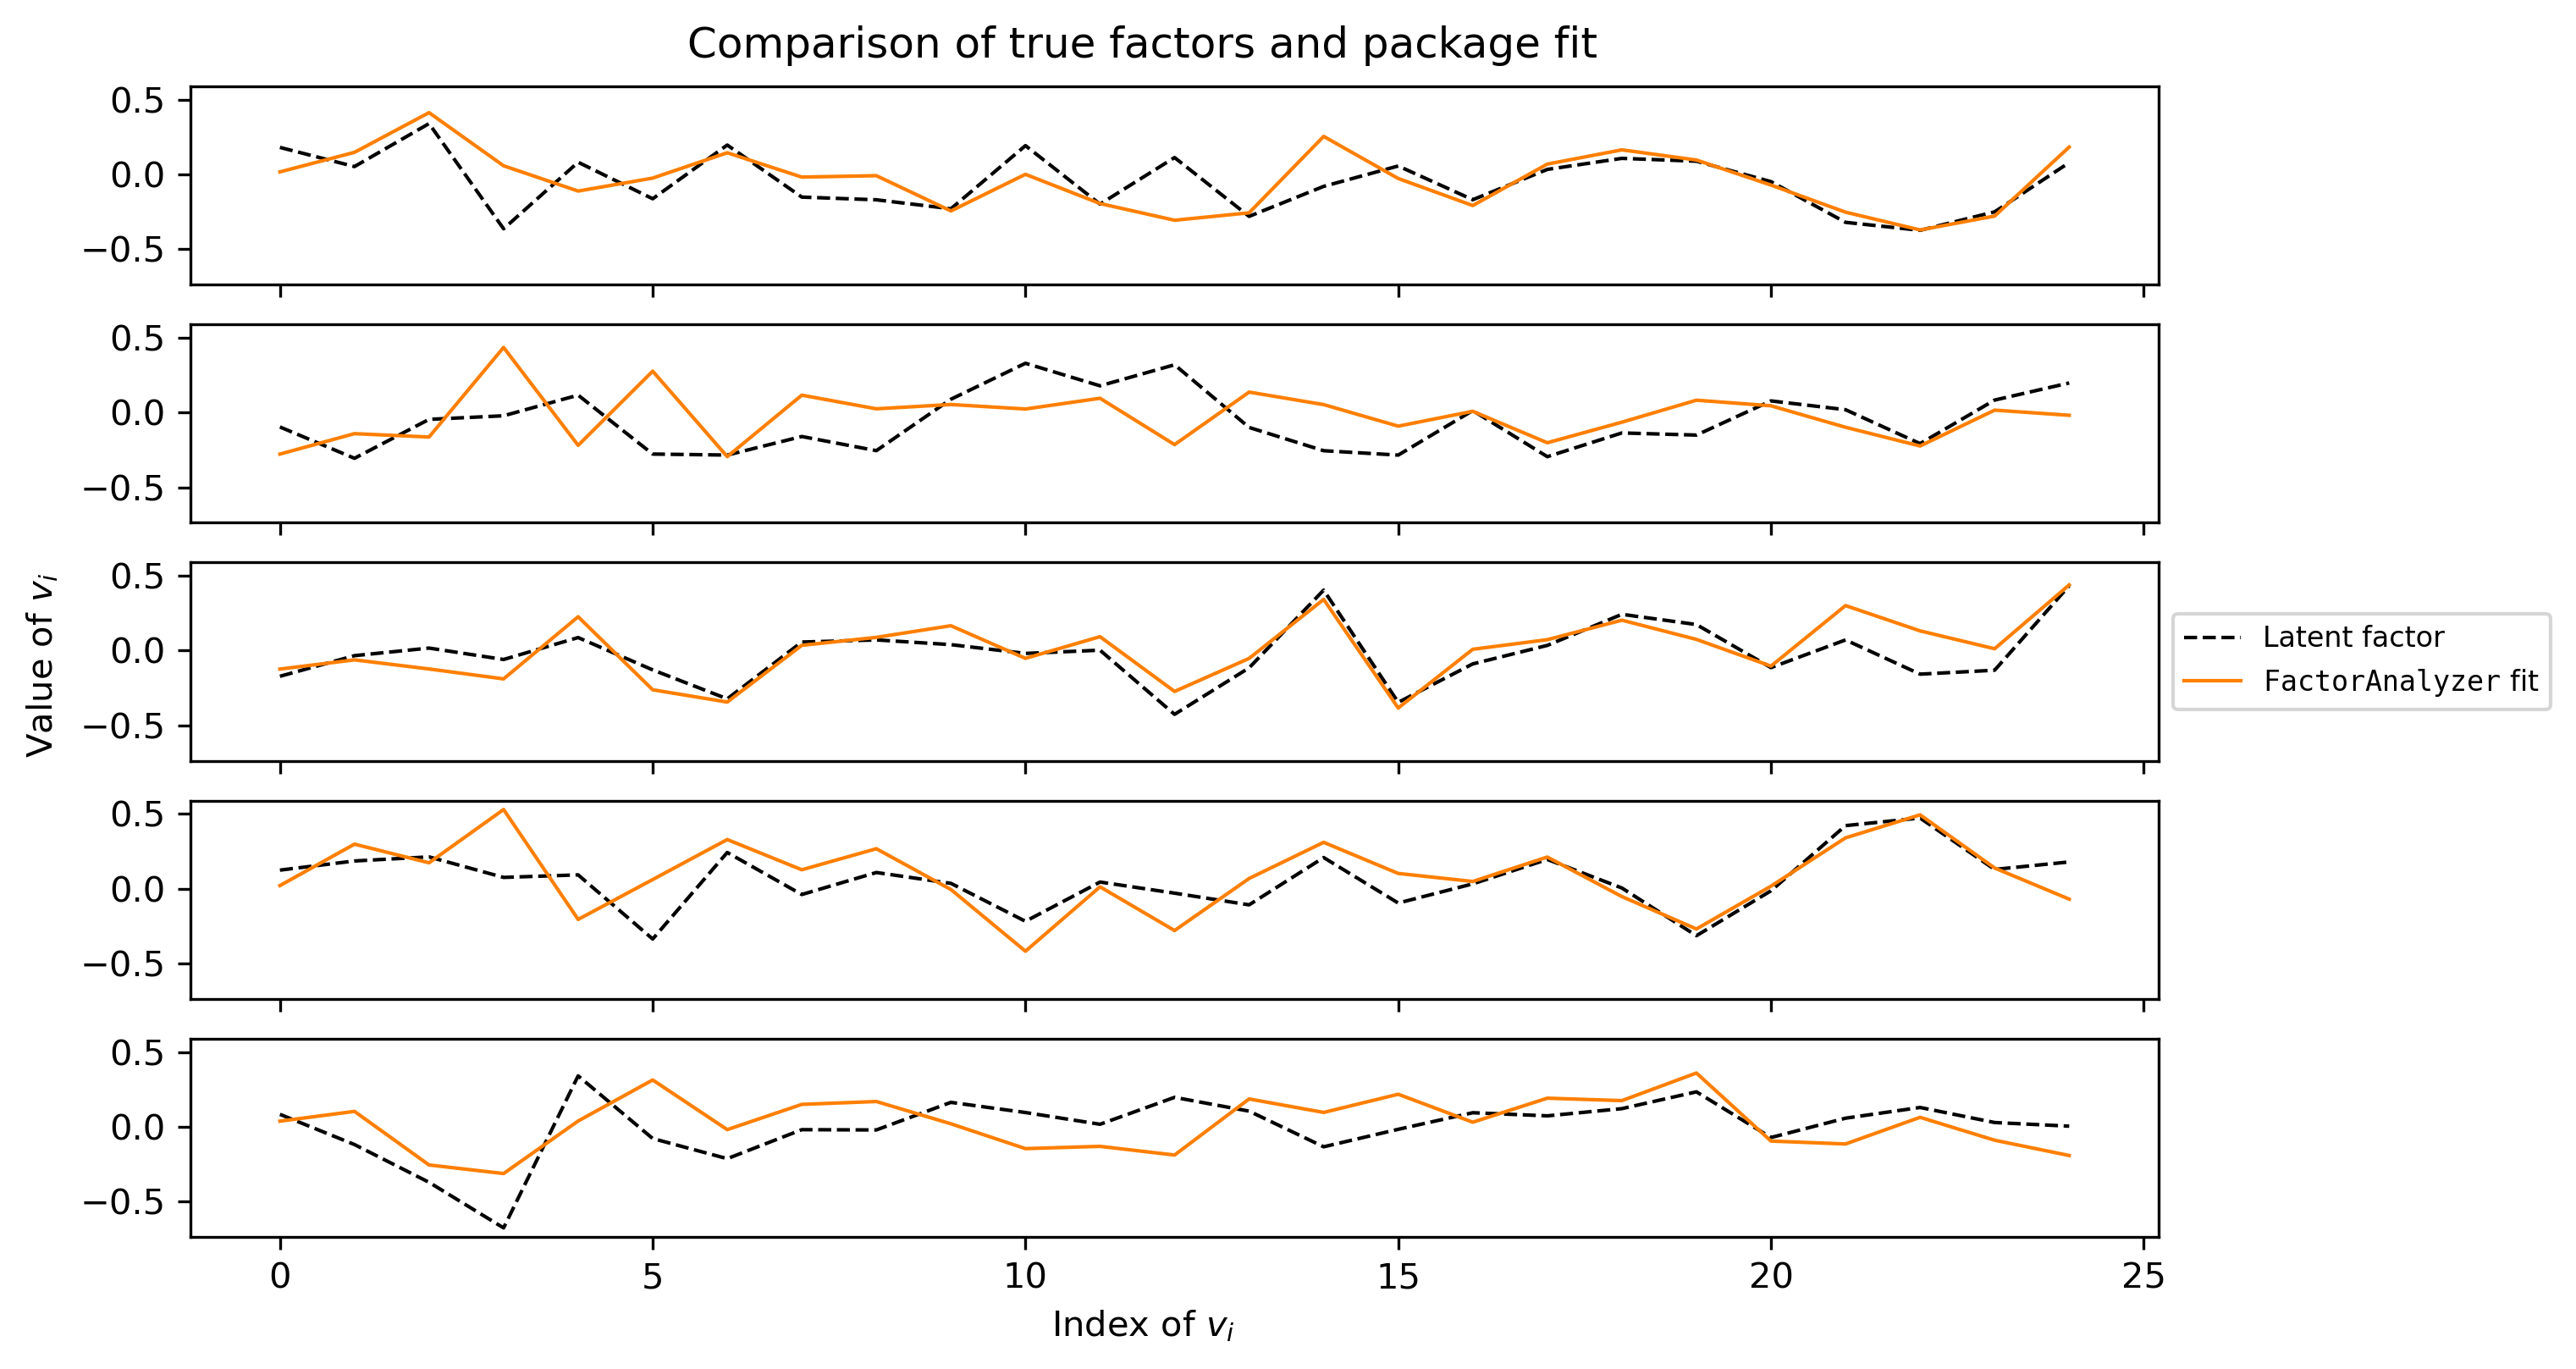

In [16]:
# creates plot comparing true latent factors and package fit
fig, axs = plt.subplots(nrows=5, ncols=1, sharex=True, sharey=True, figsize=(10, 6))

fig.text(0.5, 0.06, r"Index of $v_i$", ha='center')
fig.text(0.06, 0.5, r"Value of $v_i$", va='center', rotation='vertical')

fig.suptitle("Comparison of true factors and package fit", y = 0.92)

# creates subplots
for i in range(num_latent):

    axs[i].plot(v[i,:], label = "Latent factor", ls = "--", )
    axs[i].plot(fa_components[int(ind_best[i]),:], label = r"$\mathtt{FactorAnalyzer}$ fit")
    
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 2.9), prop={'size': 8})

plt.show()

Note that some factors may be deemed to be the best fit for more than one extracted component.

Lastly, the noise estimated by ``FactorAnalyzer`` is evaluated.

In [17]:
# estimated noise
print(fa.noise_variance_)

[1.02181284e-04 1.01893205e-04 1.00967973e-04 1.02748329e-04
 1.03687067e-04 1.01759235e-04 9.96564797e-05 1.01356609e-04
 1.00991244e-04 9.84542748e-05 9.95383702e-05 1.00704278e-04
 9.68383237e-05 1.00970170e-04 1.00640554e-04 1.00297374e-04
 1.00767458e-04 9.79919205e-05 9.90030451e-05 9.95994942e-05
 1.00885709e-04 1.01557323e-04 9.83553590e-05 9.57115493e-05
 9.97214726e-05]


***

## 3. Factor analysis from scratch

Next, we build our factor model based on ``Algorithm 21.1`` from Barber's *Bayesian Reasoning and Machine Learning* (2020).

The factor analysis model generates an observation $\mathbf{v}$ of a given dataset $\mathbf{V} = \{\mathbf{v}^1,\dots,\mathbf{v}^N\}$ according to 

$$\mathbf{V} = \mathbf{Fh} + \mathbf{M} + \mathbf{\varepsilon}.$$

Here, we use slightly different notation from Section 2. $\mathbf{V}\in \mathbb{R}^{D\times N}$ is our output observation. $\mathbf{F}\in\mathbb{R}^{D\times H}$ is our factor matrix that contains the "weights" of each factor. $\mathbf{h}\in\mathbb{R}^{H\times N}$ is our factor loading matrix. $\mathbf{M}\in \mathbb{R}^{D\times N}$ is the constant bias which is the mean in this instance.

**Algorithm 21.1**

> 1. Initialise diagonal noise $\mathbf{\Psi}$.

We initialise our noise by setting $\mathbf{\Psi}=\text{diag}(\psi_1,\dots,\psi_D)$.

In [18]:
# 1. Initialise diagonal noise
noise = 0.01*np.random.normal(size=(num_dimension,num_dimension))
psi = np.diag(np.diag(np.cov(noise)))

> 2. Find the mean $\mathbf{\bar v}$ of the data $\mathbf{v}^1,\dots, \mathbf{v}^N$.

This is our constant bias that we use to "shift" our coordinate system to better fit the data. The mean matrix is set to be ``M`` in the code.

In [19]:
# 2. Find the mean of the data
result = []
for vector in V:
    result.append([sum(vector)/len(vector)])

M = np.array(result)
print(M)

[[-0.23578659]
 [ 0.01893708]
 [-0.01146651]
 ...
 [ 0.03615655]
 [ 0.10077953]
 [ 0.05052507]]


> 3. Find the variance $\sigma_i^2$ for each component $i$ of the data $v_i^1,\dots, v_i^N$

In [20]:
#3. Find the variance
var = np.var(V, axis=0)
print(var)

[0.0945306  0.14523922 0.30898372 0.60828854 0.15578638 0.24772308
 0.33537032 0.05346267 0.1084378  0.09049598 0.20006396 0.07300214
 0.32895219 0.12633391 0.29086423 0.21409844 0.0464837  0.13225031
 0.10617358 0.22394088 0.02730535 0.29326605 0.45311533 0.10506506
 0.26943714]


> 4. Compute the centred matrix $\mathbf{X} = \mathbf{V} - \mathbf{M}$.

In [22]:
# 4. Compute the centred matrix
X = V - M
print(X)

[[ 0.04882245 -0.89853199 -0.95706563 ... -0.78851618  0.0446749
   0.7423448 ]
 [-0.27703547 -0.23597386 -0.21339391 ...  0.28991728  0.27309664
   0.36066921]
 [-0.24486666  0.08142767  0.15961889 ... -0.29139722 -0.05401942
  -0.17525128]
 ...
 [ 0.05971714  0.19077466  0.27924494 ...  0.08117038  0.01180684
  -0.34940081]
 [-0.04500002  0.7226685   0.77231202 ...  0.0851997  -0.53035574
   0.39469068]
 [-0.25224386 -0.19665322 -0.22859777 ...  0.42002714  0.43327824
  -0.24710536]]


> 5. **while** Likelihood not converged or termination criterion not reached **do**

In [26]:
# initial constants and variables
L_old = -np.infty
likelihoods = []
    
# error tolerance
tol = 1e-4

# max iterations before termination
max_iter = 100 

In [27]:
# 5. While loop runs if error is greater than tolerance or until max_iter
for i in range(max_iter):
    
    #----------------------------------------------------------------------------
    # 6. Form the scaled data matrix
    X_tilde = np.dot(np.linalg.inv(np.sqrt(psi)), X.T / (num_sample ** 0.5))
    #----------------------------------------------------------------------------
    # 7. Perform SVD for the scaled data matrix
    U,Lambda_tilde,WT = np.linalg.svd(X_tilde)
    Lambda_tilde = np.diag(Lambda_tilde)
    Lambda = Lambda_tilde ** 2
    #----------------------------------------------------------------------------
    # 8. Set U_H to the first H columns of U and set Lambda_H to contain the 
    #    first H diagonal entries of Lambda
    H = num_latent
    U_H = U[:,:H]
    Lambda_H = Lambda_tilde[:H,:H]
    #----------------------------------------------------------------------------
    # 9. Factor update
    #if i == 0:
        #F = np.copy(v.T)
    #else:
    F = np.sqrt(psi) @ U_H @ np.sqrt(Lambda_H - np.identity(H))
    #----------------------------------------------------------------------------
    # 10. Log likelihood
    a = 0
    for j in range(H):
        a += np.log(Lambda[j,j])
    b = 0
    for k in range(H+1,num_dimension):
        b += Lambda[k,k]
    
    L_new = (num_dimension/2)*(a + H + b + np.log(np.linalg.det(2*np.pi*psi)))
    likelihoods.append(L_new)
    #----------------------------------------------------------------------------
    # 11. Psi update
    psi = np.maximum(np.diag(var)-np.diag(F@F.T),1e-12)
    #----------------------------------------------------------------------------
    print("Iteration: %d" % (i+1))
    print("Loglikehood: ", L_new)
        
    if np.abs(L_new-L_old)<tol:
        break
    
    # log likelihood update
    L_old = L_new

Iteration: 1
Loglikehood:  93.02427970779104
Iteration: 2
Loglikehood:  93.0242798204862


> 12. **end while**

The following plot shows how well the model fits:

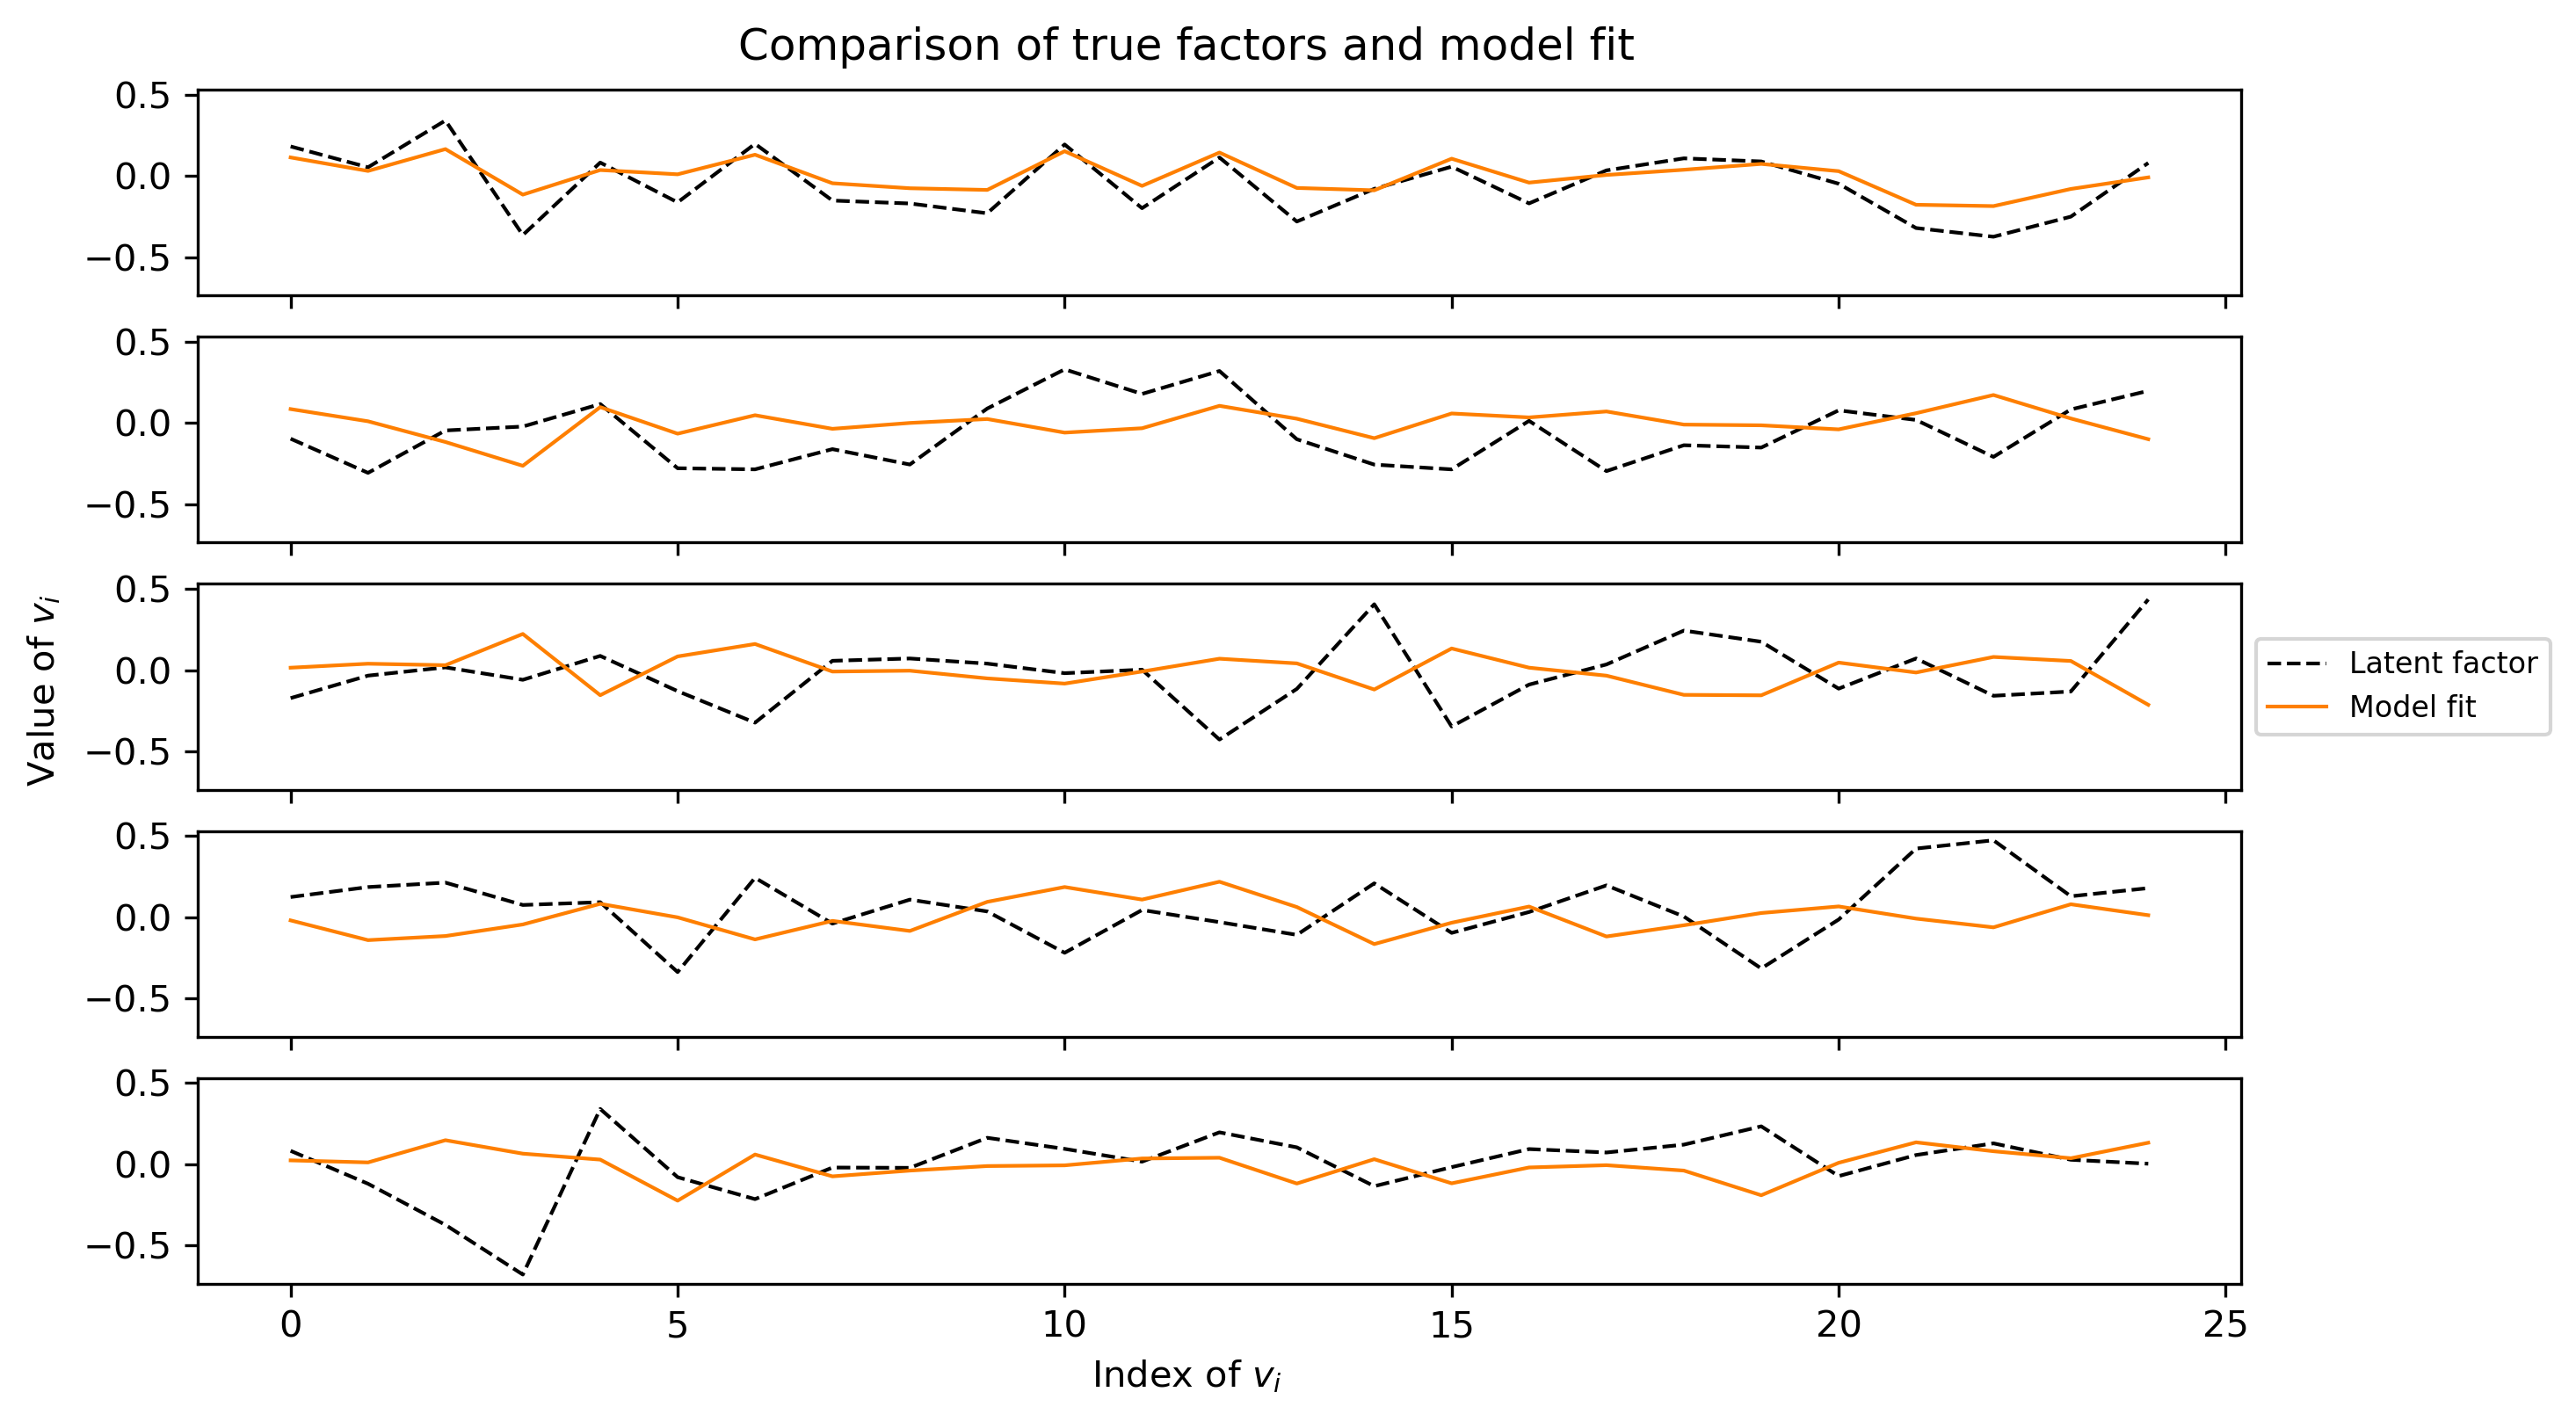

In [28]:
# creates plot comparing true latent factors and model fit
fig, axs = plt.subplots(nrows=5, ncols=1, sharex=True, sharey=True, figsize=(10, 6))

fig.text(0.5, 0.06, r"Index of $v_i$", ha='center')
fig.text(0.06, 0.5, r"Value of $v_i$", va='center', rotation='vertical')

fig.suptitle("Comparison of true factors and model fit", y = 0.92)

for i in range(num_latent):

    # creates subplots
    axs[i].plot(v[i,:], label = "Latent factor", ls = "--", )
    axs[i].plot(F.T[int(ind_best[i]),:], label = "Model fit")
    
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 2.9), prop={'size': 8})

plt.show()

The following plot shows the comparison between ``FactorAnalyzer`` and the model:

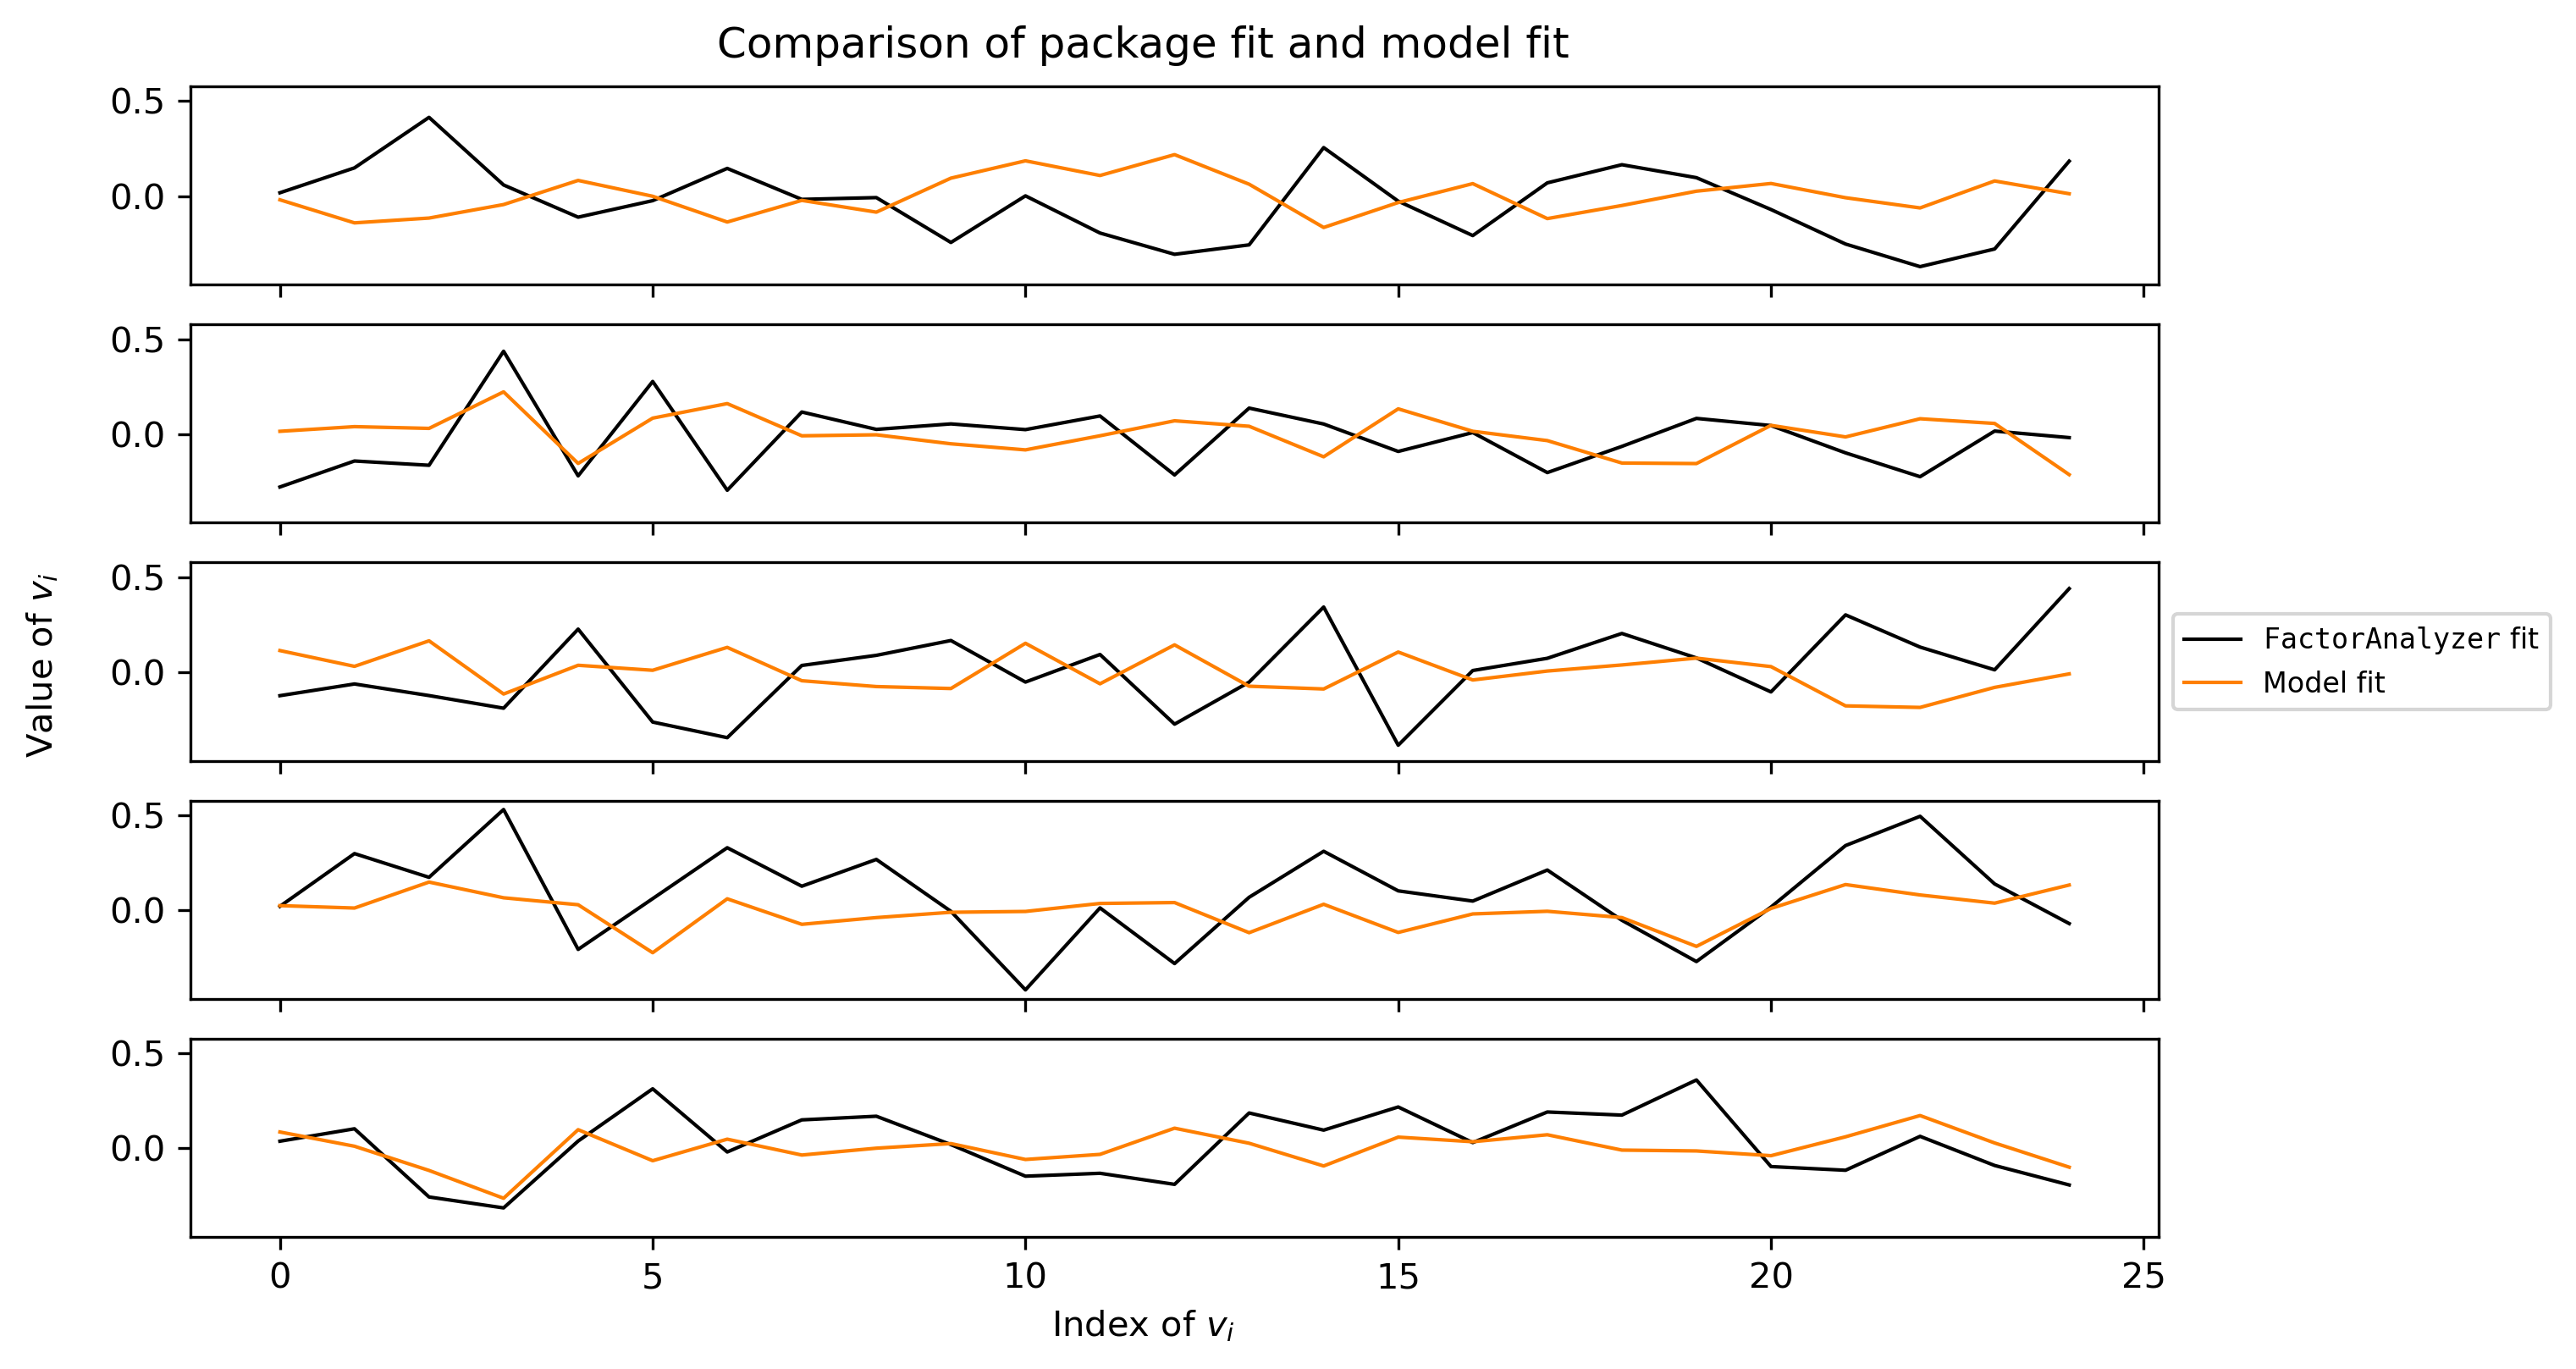

In [29]:
# creates plot comparing package fit and model fit
fig, axs = plt.subplots(nrows=5, ncols=1, sharex=True, sharey=True, figsize=(10, 6))

fig.text(0.5, 0.06, r"Index of $v_i$", ha='center')
fig.text(0.06, 0.5, r"Value of $v_i$", va='center', rotation='vertical')

fig.suptitle("Comparison of package fit and model fit", y = 0.92)

# creates subplots
for i in range(num_latent):

    axs[i].plot(fa_components[int(ind_best[i]),:], label = r"$\mathtt{FactorAnalyzer}$ fit")
    axs[i].plot(F.T[i,:], label = "Model fit")
    
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 2.9), prop={'size': 8})

plt.show()